<h1> Polynomial Regression

This cell is regarding polynomial regression, first we will grab the dataset and clean it a little bit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
nyc_pumpkins = pd.read_csv("./new-york_9-24-2016_9-30-2017.csv")
cat_map = {
    'sml': 0,
    'med': 1,
    'med-lge': 2,
    'lge': 3,
    'xlge': 4,
    'exjbo': 5
}
nyc_pumpkins = nyc_pumpkins.assign(
    size=nyc_pumpkins['Item Size'].map(cat_map),
    price=nyc_pumpkins['High Price'] + nyc_pumpkins['Low Price'] / 2,
    size_class=(nyc_pumpkins['Item Size'].map(cat_map) >= 2).astype(int)
)
nyc_pumpkins = nyc_pumpkins.drop([c for c in nyc_pumpkins.columns if c not in ['size', 'price', 'size_class']], 
                                 axis='columns')
nyc_pumpkins = nyc_pumpkins.dropna()

In [3]:
nyc_pumpkins.head(10)

,size,price,size_class
0,4.0,245.0,1
1,3.0,245.0,1
2,4.0,215.0,1
3,3.0,215.0,1
4,2.0,200.0,1
5,4.0,245.0,1
6,3.0,230.0,1
7,1.0,280.0,0
8,4.0,245.0,1
9,3.0,245.0,1


In [4]:
nyc_pumpkins.shape

(104, 3)

Now we will split into train and test set with the useful train_test_split method from sklearn. We will test with polynomials of degree 1,2 and 4. Remember a polynomial of dgree 1 is just linear regression!

In this case as we want to predict the size which is an integer, we will round up the predicted value and we will how close we are with a distance of 1 class. 

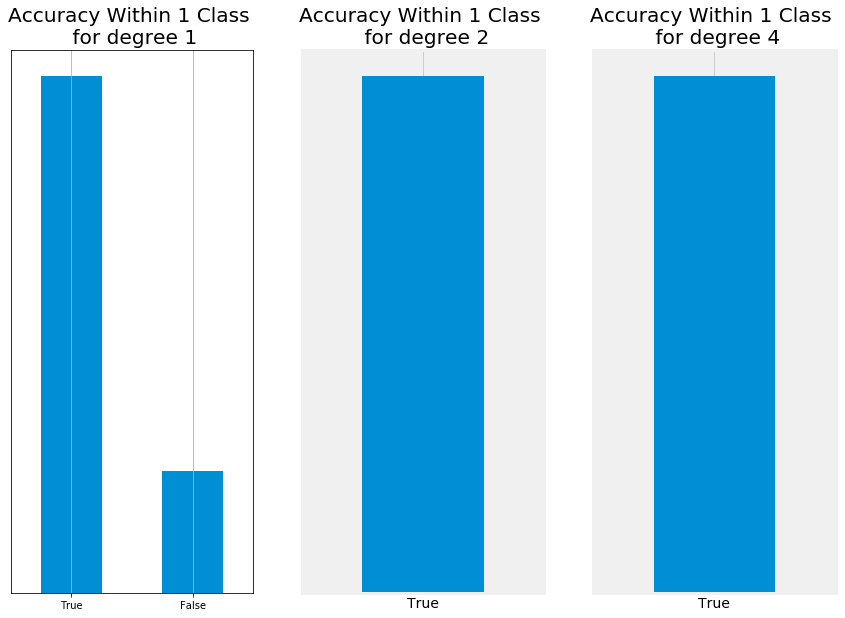

In [5]:
X_train, X_test, y_train, y_test = train_test_split(nyc_pumpkins['price'], nyc_pumpkins['size'], test_size=0.20, random_state=42, shuffle=True) #split 20% into test set

degrees = [1, 2, 4]
fig = plt.figure(figsize=(20,10))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees)+1, i + 2)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train[:, np.newaxis], y_train)

    # Evaluate the models using crossvalidation
    predicted_sizes = np.round(pipeline.predict(X_test[:, np.newaxis]))
    import matplotlib.pyplot as plt
    plt.style.use('fivethirtyeight')

    pd.Series(
        np.abs((np.array(y_test) - predicted_sizes).flatten()) <= 1
    ).value_counts().plot.bar(title='Accuracy Within 1 Class \n for degree {}'.format(degrees[i]))

We did pretty good with polynomial regression! Lets analyze how well it can generalize. one problem with degree 4 we will have is correlation, lets check it! 

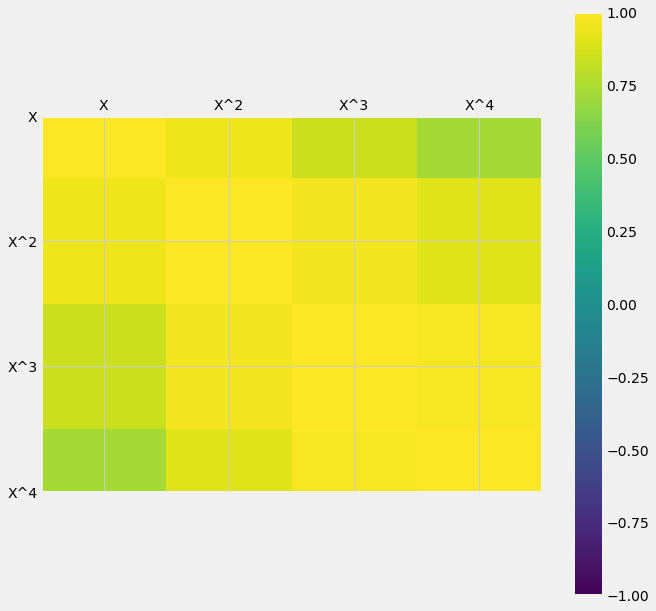

In [6]:
correlations = pd.DataFrame(PolynomialFeatures(degree=4, include_bias=False).fit_transform(np.array(nyc_pumpkins['price']).reshape(-1,1))).corr()
# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,4,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(['X', 'X^2', 'X^3', 'X^4'])
ax.set_yticklabels(['X', 'X^2', 'X^3', 'X^4'])
plt.show()

Thats bad! Finally, to see what is the issue with polynomial regression, lts add just *ONE* outlier!

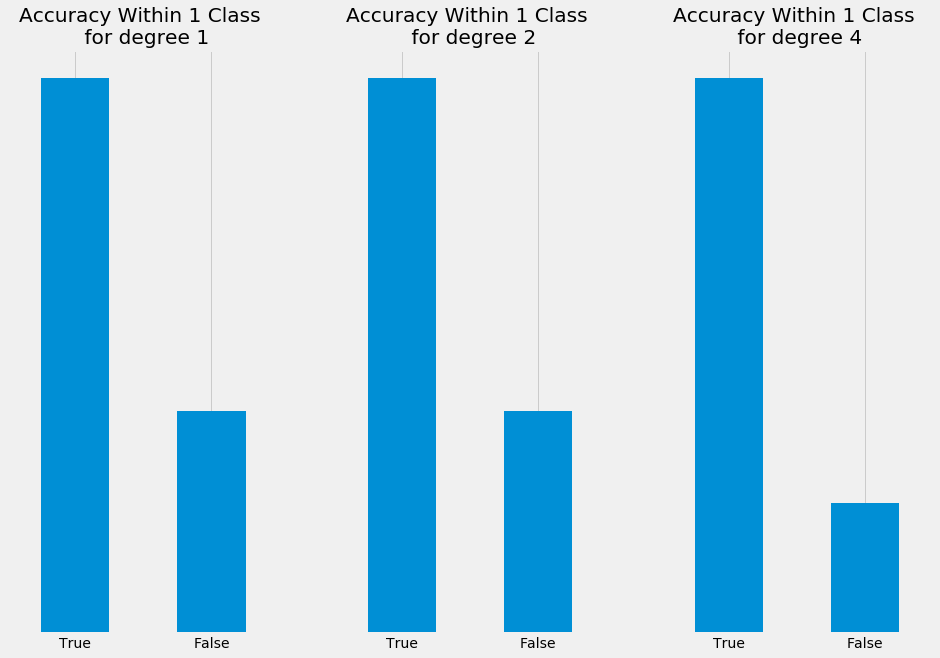

In [7]:
X_train, X_test, y_train, y_test = train_test_split(nyc_pumpkins['price'], nyc_pumpkins['size'], test_size=0.20, random_state=42, shuffle=True) #split 20% into test set

X_train[20]= -10
y_train[20] = 30

degrees = [1, 2, 4]
fig = plt.figure(figsize=(20,10))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees)+1, i + 2)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train[:, np.newaxis], y_train)

    # Evaluate the models using crossvalidation
    predicted_sizes = np.round(pipeline.predict(X_test[:, np.newaxis]))
    import matplotlib.pyplot as plt
    plt.style.use('fivethirtyeight')

    pd.Series(
        np.abs((np.array(y_test) - predicted_sizes).flatten()) <= 1
    ).value_counts().plot.bar(title='Accuracy Within 1 Class \n for degree {}'.format(degrees[i]))

Polynomial regression is really non robust!